# Final Project For N-Body

### Code:

In [2]:
import numpy as np
import numba as nb
from matplotlib import pyplot as plt
from scipy import fft
import math

In [2]:
class particles:
    def __init__(self,number_of_particles, grid_size,soft, periodic):
        self.grid_size = grid_size
        self.number_of_particles = number_of_particles
        self.soft = soft
        self.periodic = periodic

        self.coordinates=np.zeros([number_of_particles,2])
        self.cell_coordinates = np.zeros([number_of_particles,2])
        self.gradient=np.empty([number_of_particles,2])
        self.masses=np.ones(number_of_particles)
        self.forces = np.zeros([number_of_particles,2])
        self.velocities = np.zeros([number_of_particles,2])
        self.one_particle_pot = np.zeros([self.grid_size,self.grid_size])
        self.densities=np.zeros([self.grid_size,self.grid_size])
        self.potentials=np.zeros([self.grid_size,self.grid_size])
    def closest_cell(self):
        new_coor = np.transpose(self.coordinates.copy())
        if self.number_of_particles == 1:
            new_coor[0] = math.floor(new_coor[0])+0.5
            new_coor[1] = math.floor(new_coor[1])+0.5
        else:
            for i in range(2):
                for j in range(self.number_of_particles):
                    new_coor[i][j] = math.floor(new_coor[i][j])+0.5
        self.cell_coordinates = np.transpose(new_coor)
    def set_density(self):
        self.densities = np.zeros([self.grid_size,self.grid_size])
        
        self.closest_cell()
        rho = self.densities
        coor = self.cell_coordinates
        for i in range(self.number_of_particles):
            x = int(-coor[i][1]+self.grid_size/2 - 0.5)
            y = int(coor[i][0]+self.grid_size/2 - 0.5)
            if self.masses[i] > 0:
                rho[x][y] = rho[x][y] + self.masses[i]
    def set_potential(self):
        self.set_density()
        self.potentials=np.around(fft.irfft2(fft.rfft2(self.densities)*fft.rfft2(self.one_particle_pot),[self.grid_size,self.grid_size]),2)
    def set_one_particle_pot(self):
        x=np.fft.fftfreq(self.grid_size)*self.grid_size
        rsqr=np.outer(np.ones(self.grid_size),x**2)
        rsqr=rsqr+rsqr.T
        rsqr[rsqr<self.soft**2]=self.soft**2
        kernel=rsqr**-0.5
        self.one_particle_pot = np.around(kernel, 2)
    def take_step(self,dt):
        self.coordinates=np.around(self.coordinates+dt*self.velocities,4)
        self.check_coor()
        self.set_potential()
        self.set_forces()
        self.velocities=np.around(self.velocities+self.forces*dt,4)
    def check_coor(self):
        for i in range(self.number_of_particles):
            x = self.coordinates[i][0]
            y = self.coordinates[i][1]
            if self.periodic:
                if abs(int(x)) >= self.grid_size//2:
                    if x < 0:
                        self.coordinates[i][0] = x + self.grid_size
                    else:
                        self.coordinates[i][0] = x - self.grid_size
                if abs(int(y)) >= self.grid_size//2 :
                    if y < 0:
                        self.coordinates[i][1] = y + self.grid_size
                    else: 
                        self.coordinates[i][1] = y - self.grid_size
            else:
                if abs(int(x)) >= self.grid_size//2:
                    self.masses[i] = 0
                    continue
                if abs(int(y)) >= self.grid_size//2 :
                    self.masses[i] = 0
                    continue
    def locate(self, coor, check):
        for i in range(self.number_of_particles):
            if check[0] == coor[i][0] and check[1] == coor[i][1]:
                return i
    def get_grad(self):
        x_grad, y_grad = np.array(np.gradient(self.potentials))
        coor = self.cell_coordinates
        self.gradient = []
        for i in range(self.number_of_particles):
            x = int(-coor[i][1]+self.grid_size/2 - 0.5)
            y = int(coor[i][0]+self.grid_size/2 - 0.5)
            if self.masses[i] > 0:
                self.gradient.append(np.array([x_grad[x][y],y_grad[x][y]]))
            else:
                self.gradient.append(np.array([0,0]))
    def set_forces(self):
        self.get_grad()
        self.forces = np.around(np.array(self.gradient),4)
        

## Part 1:

Using this code, show that a single particle starting at rest
remains motionless.

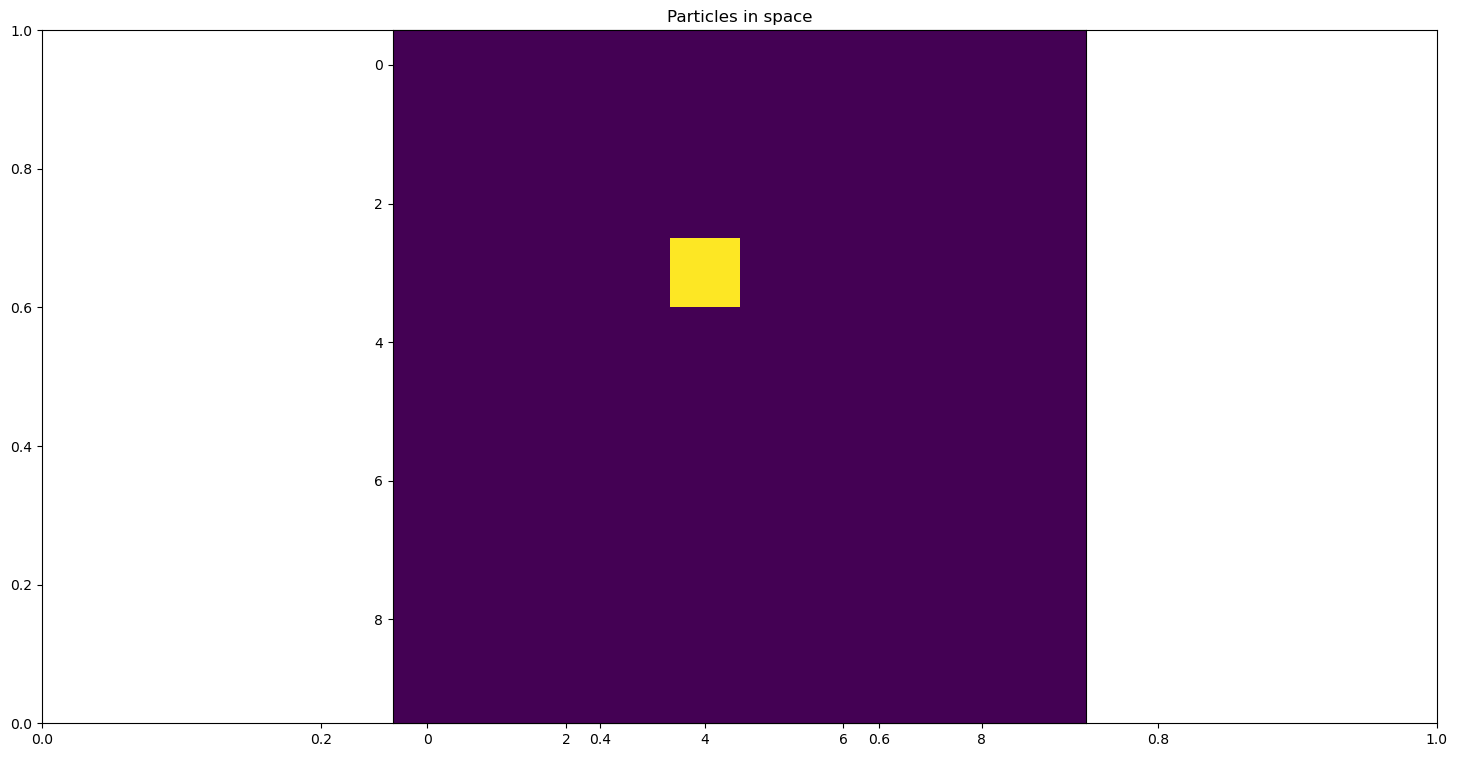

In [8]:
np.random.seed(1)
num_part = 1
grid_size = 10
parts=particles(num_part, grid_size, 2, True)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()


fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)

## Part 2:

Next, show that a pair of particles placed in a circular orbit continue to orbit each other, for at least some reasonable length of time.

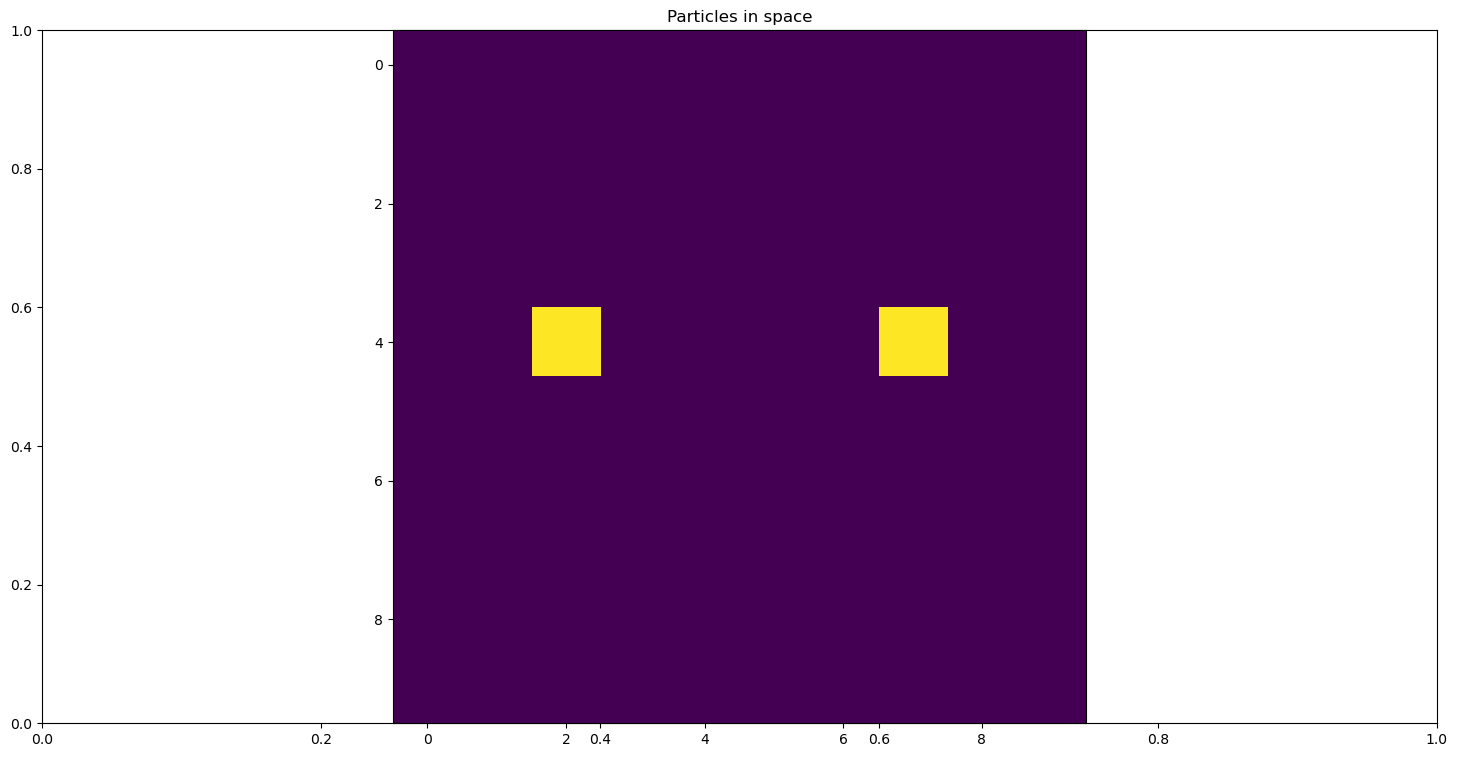

KeyboardInterrupt: 

In [9]:
np.random.seed(1)
num_part = 100000
grid_size = 1000
parts=particles(num_part, grid_size, 2, True)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()


fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)


## Part 3:

Set up both periodic and non-periodic boundary conditions. Set up a problem where at least hundreds of thousands of particles are initially scattered randomly throughout the domain. Show the evolution with time or both periodic and non-periodic boundary conditions. Track the total energy - how well is it conserved?

Periodic:

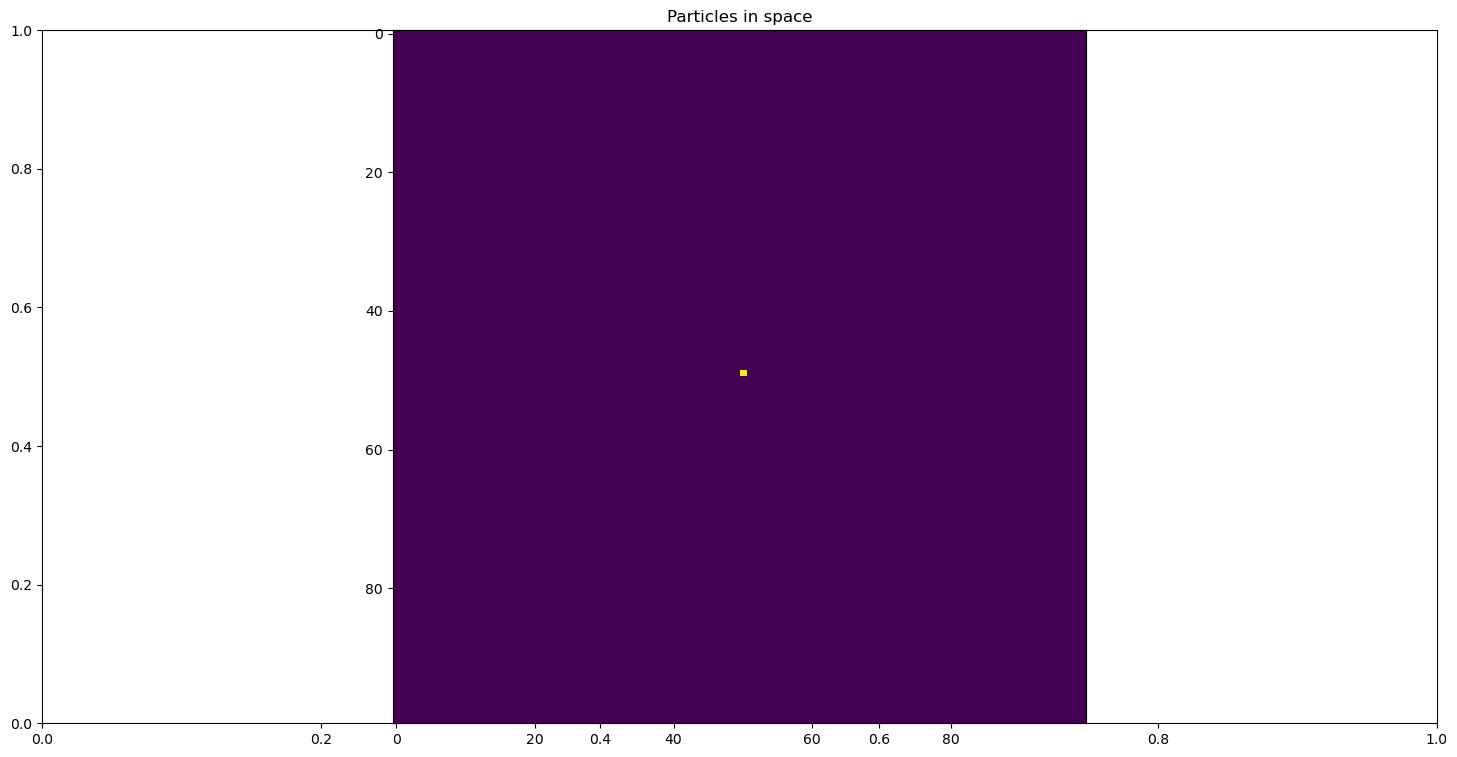

In [5]:
np.random.seed(2)
num_part = 100000
grid_size = 100
parts=particles(num_part, grid_size, 1, True)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)


parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()

fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)

 Non-periodic

In [ ]:
np.random.seed(2)
num_part = 100000
grid_size = 100
parts=particles(num_part, grid_size, 1, False)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)

parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()

fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)

## Part 4:

Switch to an RK4 integrator from a leapfrog. At fixed computational work per unit time in the simulation, which integrator preserves energy better? You may assume the work is dominated by the calls to get forces. Output should be in “rk4 periodic.gif” and “rk4 nonperiodic.gif”. Please use the same initial conditions (and starting seeds) as in part 3.

In [ ]:
def rk4(x,y,h):
    k1=y*h
    k2=h*(y+k1/2)
    k3=h*(y+k2/2)
    k4=h*(y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    return y+dy
class particles:
    def __init__(self,number_of_particles, grid_size,soft, periodic):
        self.grid_size = grid_size
        self.number_of_particles = number_of_particles
        self.soft = soft
        self.periodic = periodic

        self.coordinates=np.zeros([number_of_particles,2])
        self.cell_coordinates = np.zeros([number_of_particles,2])
        self.gradient=np.empty([number_of_particles,2])
        self.masses=np.ones(number_of_particles)
        self.forces = np.zeros([number_of_particles,2])
        self.velocities = np.zeros([number_of_particles,2])
        self.one_particle_pot = np.zeros([self.grid_size,self.grid_size])
        self.densities=np.zeros([self.grid_size,self.grid_size])
        self.potentials=np.zeros([self.grid_size,self.grid_size])
    def closest_cell(self):
        new_coor = np.transpose(self.coordinates.copy())
        if self.number_of_particles == 1:
            new_coor[0] = math.floor(new_coor[0])+0.5
            new_coor[1] = math.floor(new_coor[1])+0.5
        else:
            for i in range(2):
                for j in range(self.number_of_particles):
                    new_coor[i][j] = math.floor(new_coor[i][j])+0.5
        self.cell_coordinates = np.transpose(new_coor)
    def set_density(self):
        self.densities = np.zeros([self.grid_size,self.grid_size])
        
        self.closest_cell()
        rho = self.densities
        coor = self.cell_coordinates
        for i in range(self.number_of_particles):
            x = int(-coor[i][1]+self.grid_size/2 - 0.5)
            y = int(coor[i][0]+self.grid_size/2 - 0.5)
            if self.masses[i] > 0:
                rho[x][y] = rho[x][y] + self.masses[i]
    def set_potential(self):
        self.set_density()
        self.potentials=np.around(fft.irfft2(fft.rfft2(self.densities)*fft.rfft2(self.one_particle_pot),[self.grid_size,self.grid_size]),2)
    def set_one_particle_pot(self):
        x=np.fft.fftfreq(self.grid_size)*self.grid_size
        rsqr=np.outer(np.ones(self.grid_size),x**2)
        rsqr=rsqr+rsqr.T
        rsqr[rsqr<self.soft**2]=self.soft**2
        kernel=rsqr**-0.5
        self.one_particle_pot = np.around(kernel, 2)
    
    def take_step(self,dt):
        
        self.coordinates=np.around(rk4(self.coordinates,self.velocities,dt),4)
        self.check_coor()
        self.set_potential()
        self.set_forces()
        self.velocities=np.around(rk4(self.velocities,self.forces,dt),4)
    def check_coor(self):
        for i in range(self.number_of_particles):
            x = self.coordinates[i][0]
            y = self.coordinates[i][1]
            if self.periodic:
                if abs(int(x)) >= self.grid_size//2:
                    if x < 0:
                        self.coordinates[i][0] = x + self.grid_size
                    else:
                        self.coordinates[i][0] = x - self.grid_size
                if abs(int(y)) >= self.grid_size//2 :
                    if y < 0:
                        self.coordinates[i][1] = y + self.grid_size
                    else: 
                        self.coordinates[i][1] = y - self.grid_size
            else:
                if abs(int(x)) >= self.grid_size//2:
                    self.masses[i] = 0
                    continue
                if abs(int(y)) >= self.grid_size//2 :
                    self.masses[i] = 0
                    continue
    def locate(self, coor, check):
        for i in range(self.number_of_particles):
            if check[0] == coor[i][0] and check[1] == coor[i][1]:
                return i
    def get_grad(self):
        x_grad, y_grad = np.array(np.gradient(self.potentials))
        coor = self.cell_coordinates
        self.gradient = []
        for i in range(self.number_of_particles):
            x = int(-coor[i][1]+self.grid_size/2 - 0.5)
            y = int(coor[i][0]+self.grid_size/2 - 0.5)
            if self.masses[i] > 0:
                self.gradient.append(np.array([x_grad[x][y],y_grad[x][y]]))
            else:
                self.gradient.append(np.array([0,0]))
    def set_forces(self):
        self.get_grad()
        self.forces = np.around(np.array(self.gradient),4)
        

Periodic

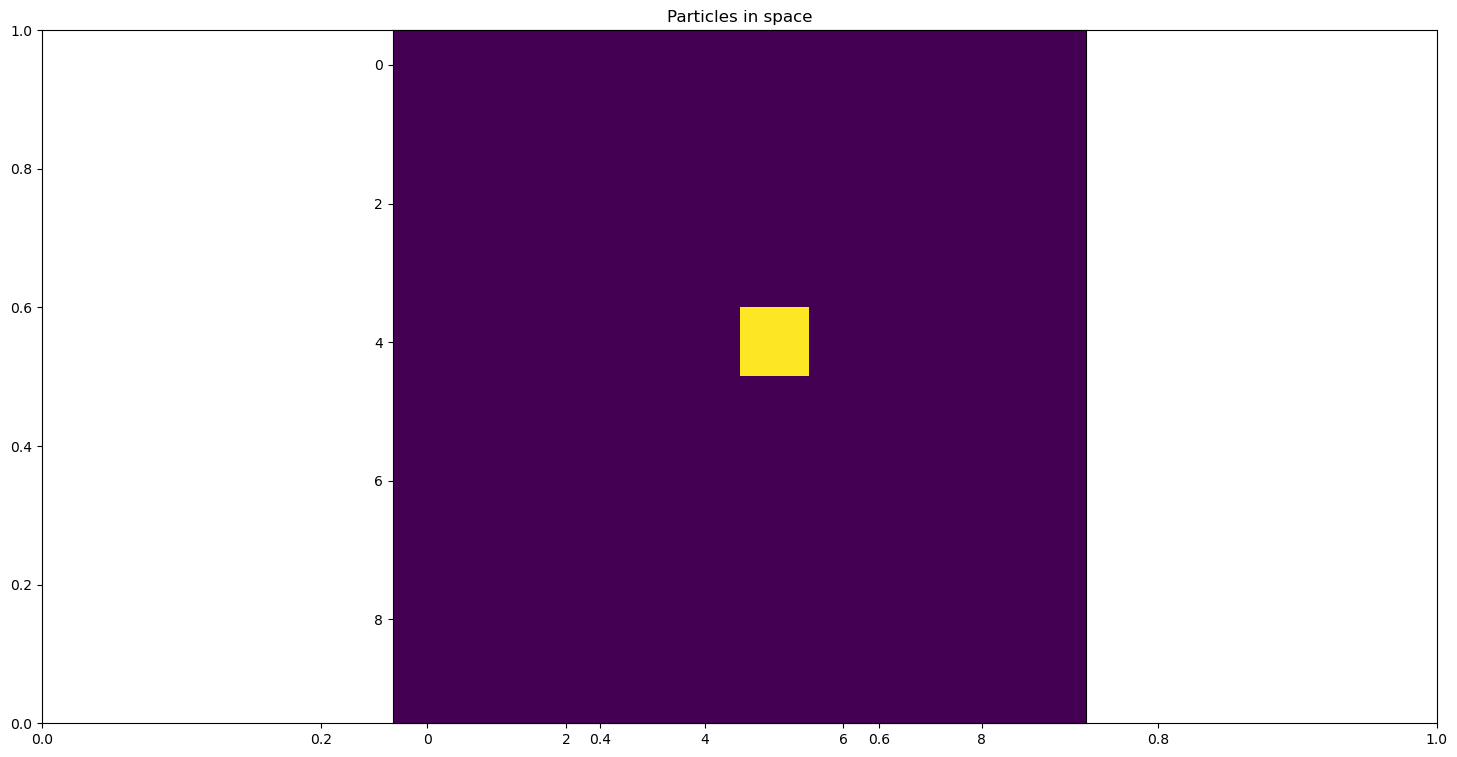

In [ ]:
np.random.seed(2)
num_part = 100000
grid_size = 100
parts=particles(num_part, grid_size, 1, True)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)


parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()

fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)

Non periodic

In [ ]:
np.random.seed(2)
num_part = 2
grid_size = 10
parts=particles(num_part, grid_size, 1, False)
x = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)
y = np.around(np.random.uniform(low=-grid_size//2+1, high=grid_size//2-1, size=(num_part,)),2)

parts.coordinates = np.array([x, y]).transpose()
parts.set_one_particle_pot()
parts.set_density()

fig = plt.figure(figsize=(18,9))
plt.title("Particles in space")
ax = fig.add_subplot(111)
crap=ax.imshow(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)

for i in range(300):
    parts.take_step(dt=0.1)
    crap.set_data(parts.densities[:parts.grid_size,:parts.grid_size]**0.5)
    plt.pause(0.1)

NameError: name 'np' is not defined

In the end, we seem to have a problem with our computation of the gradient. Indeed, our gradient did not give the proper attractive for like we would expect. So for the sake of time, we used our rk4 integrator on john's code to check our hypothesis which is that the rk4 integrator allows a better conservation of energy because it is more precise then the leapfrog.